In [2]:
# this is some code to get pretty highlighted cells for the questions - ignore this
from IPython.display import HTML
style1 = "<style>div.warn { background-color: #fcf2f2;border-color: #dFb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;}</style>"
HTML(style1)

This notebook covers some worked examples and some examples for you to try relating to **Block B, Chapter 6** in the notes.  This is practice and core material for coursework 2 and 3. The green questions are those most closely related to the assessed work for this module.  *Once you have completed this workbook you should be able to attempt QN 2 on coursework 2.*


## Generating random datasets

**Worked Example**

Here's a worked example of generating 5000 random datasets from a gaussian distribution with mean $\mu=3$ and standard deviation $\sigma = 1.0$.

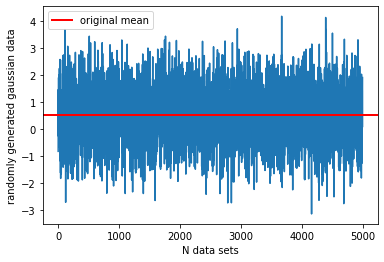

In [7]:
import numpy as np
import pylab as plt

%matplotlib inline

# set up our mean and sigma
mu = 0.5
sigma = 1.0
nPoints=5000  # nice large number so that we can start to approximate the PDF

randomG_data = np.random.normal(mu,sigma,size=nPoints)

# what does this data look like - let's plot it!
plt.plot(randomG_data)
plt.xlabel('N data sets')
plt.ylabel('randomly generated gaussian data')
plt.axhline(0.5,label='original mean',c='r',lw=2)
plt.legend()


Text(0, 0.5, 'Number data sets')

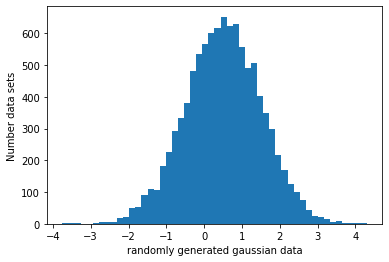

In [4]:
plt.hist(randomG_data,bins=50)
plt.xlabel('randomly generated gaussian data')
plt.ylabel('Number data sets')

## Monte Carlo Markov Chain

The main goal of MCMC is to provide an approximation to a probability distribution. This is extremely useful. Although we have random number generators for uniform, normal, and sometimes binomial/Bernoulli/Poisson distributions, these can only get us so far. For example, the kind of pdfs that commonly appear in Bayesian analysis are often complicated functions, which are hard, or even impossible, to put in an analytic pdf form. MCMC allows us to get around these problems.

MCMCs stochastically explore the parameter space in such a way that the histogram of their samples produces the target distribution.

**The general form of the Metropolis algorithm**

We are trying to draw numbers from a target distribution that we will denote as $P(\theta)$. The following steps outline the algorithm

Make a first guess at the dependent variable (or variables) $\theta_{current}$. We then propose to make a random step in the variables to a new location 

$\theta_{proposed} = \theta_{current} + \Delta_{\theta}$.

If the value of the function at $\theta_{proposed}$ is greater than that at $\theta_{current}$ -- i.e.
 
$P(\theta_{proposed}) > P(\theta_{current})$

then we accept a move to the point $\theta_{proposed}$. However, if

$P(\theta_{proposed}) < P(\theta_{current})$

then we consider the probability of the move to $\theta_{proposed}$ as

$p_{move} = \dfrac{ P(\theta_{proposed}) }{ P(\theta_{current}) }.$

All this can actually be tidied up by simply writing

$p_{move} = \text{min} \left( \dfrac{ P(\theta_{proposed}) }{ P(\theta_{current}) } , 1 \right)$

If $p_{move} < 1$, then we still have a decision to make. We now use draw a *uniform random number* between 0 and 1 which we will denote as $u_{rnd}$. If

$u_{rnd} \leq p_{move}$

then the proposed move is accepted. If not, we reject the move and stay where we are.

Once the decision is made to accept/reject the point, we update $\theta_{current}$ with the new position (which could be the same position if the move was rejected!) and store its value.

Repeat by going back to the first step, only now we don't have to guess since we have just moved to $\theta_{current}$.

**MCMC for evaluating posteriors**

One of the most common uses of MCMCs is to obtain a representative sample of points from the posterior,

$p(\theta | D) \propto p(D | \theta) p(\theta)$

In this case we make $p(D | \theta) p(\theta)$ our target distribution for the MCMC, and the chain of points that results from our converged MCMC run is then a random sample from the Bayesian posterior. This is especially important if our posterior is multivariate (i.e. $\theta$ is not one variable, but rather represents a whole host of variables), since then the simpler grid approximations become numerically unwieldy. And once again, we need not worry about trying to normalise  $p(D | \theta) p(\theta)$, since MCMC does not care if the function that it is evaluating is normalised or not (only that it is non-negative).

Once one has a representative sample from the posterior, there are many things that we can do! For example, we can calculate the mean (expectation value) from the points, the variance, etc. That is often enough, which is why we do not always need to produce a normalised posterior.

Even if a normalised posterior is required, it can often be done simply by creating a normalised histogram of the resulting MCMC points. If the multivariate, this can be done on each variable in turn -- that is, first making a histogram of all points that have $\theta_1$, then another with all points that have $\theta_2$, etc. By doing this, you are essentially *marginalising* over the other variables. Once you have your normalised posterior, you can then use it to calculate the HDI of the various marginalised posteriors, which can be useful for hypothesis testing.

**Key features of MCMC**

One of the key features of MCMC is that the decision to move is dependent on the ratio of the target distribution,

$p_{move} = \text{min} \left( \dfrac{ P(\theta_{proposed}) }{ P(\theta_{current}) } , 1 \right)$

This means that the function that holds the shape of the target distribution does not need to be normalised.  In fact, that is often the point. The functions for which we use MCMC are often those which are difficult or impossible to normalise - this is really useful for the denominator of Bayes.

The only real condition on P(θ) is that it is positive (negative probabilities are not a good idea).

**Testing for convergence**

The simplest way to assess convergence is to monitor the properties of your sample until any trends have disappeared, such as an increasing mean, or oscillating skewness, etc. It is also good monitor this over different lengths of $N$ within your chain. For example, after 1 million points have been generated, you could try comparing the various moments of the first 1000 points, with the last. This will also start to give you  a feel for where the burn-in period ends. Or you plot the mean,std,variance for each 100 points, and see at which point in the chain these values start to settle down.

In code speak - this would look like

`burnin=100
burnt_sample = sample[burnin:]`

This would take out the first 100 entries in your MCMC output.

A more worrying problem is the case in which your well sampled chain has become stuck in a not very important peak. Thankfully, a simple solution is at hand: do several chains with different starting positions and/or step sizes, and allow them to independently explore the pdf. Again you can compare the properties of the various chains at different stages, to see how well they are doing. If one chain has a very different mean, say, than the others, then it is likely that it has become stuck in far-off maximum. 

For cases where the MCMC results look clumpy, you can perform *thinning*, whereby you only accept each $n$th value from the chain and throw away the rest. To decide on $n$,  you can either simply look at the data.

To thin the data in a code, this would look like
`length=20
independentsamples = sample[::length]`

This would pull out numbers every 20 points+initial guess such that you would return 6 independent samples if your length is 20 and your MCMC was only 100 trials.  If you did 1000 trials, this would then return 51 values from your original 1000.

You could also perform some sort of correlation statistic on sets of $n$ points, to see where the correlations end. To do this we want to check  how correlated a sample $i$ is to sample $i-1$, $i-2$ etc.  Matplotlib has a library for this `plt.accor(data-mean(data),maxlags=10)`, see example below.  This checks the differences in a sample of data ahead of the current sample $X_{i+k}$, where the current sample is $X_i$.  We refer to the lag $k$ as the range ahead of the current sample:

$r_k = \dfrac{\sum (X_i - \hat{X})(X_{i+k}-\hat{X})}{\sum (X_i - \hat{X})^2}.$

## Worked example autocorrelation

Text(0.5, 0, 'Number of lags')

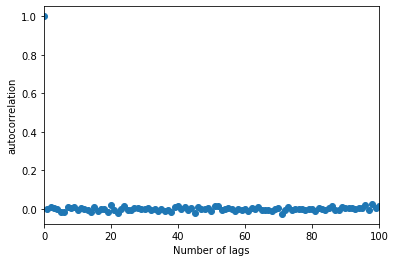

In [5]:
#plot autocorrelation for the random data generated above
plt.acorr(randomG_data-np.mean(randomG_data), maxlags=100, normed=True, usevlines=False);
plt.xlim(0,100)
plt.ylabel('autocorrelation')
plt.xlabel('Number of lags')

One thing to note is that the values returned from MCMC are not strictly the same as those that you would get from, say, a Gaussian random number generator. This is because successive terms in the chain depend on one another (even when the chain doesn't look clumpy). Thankfully there is another easy way to deal with this. We simply perform our chain, and then randomise the order in which we sample from it.

***
## Your Turn
***

<div class="alert alert-block alert-success">Question:<br><br>

Generate 1000 sets of random data to represent flipping a coin 10 times and getting 5 heads.  Plot the distribution.
</div>

**Answer:**

0.5003


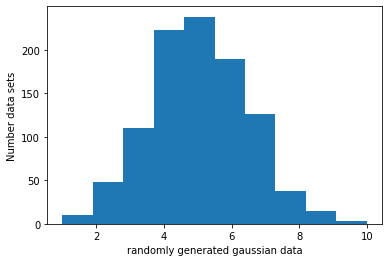

In [25]:
import numpy as np
import pylab as plt

%matplotlib inline

# set up our mean and sigma
n = 10
p = 0.5
nPoints=1000  # nice large number so that we can start to approximate the PDF

randomG_data = np.random.binomial(n,p, size=nPoints)

mean = np.mean(randomG_data)/n
plt.hist(randomG_data,bins=10)
plt.xlabel('randomly generated gaussian data')
plt.ylabel('Number data sets')
print(mean)


<div class="alert alert-block alert-success">Question:<br><br>
Here we will show that an MCMC can recover an underlying posterior distribution if we assume the distribution is Gaussian. We will return to the heights example in the previous session.<br><br>


We have 10 measurement of student heights in cm = [169.6,166.8,157.1,181.1,158.4,165.6,166.7,156.5,168.1,165.3]<br><br>

The variance in the measurement is 50cm. The prior data is normally distributed with mean = 170cm and standard deviation of 3cm. <br><br>

a. Define a function in python to calculate the posterior probability for a value theta, given likelihood and prior data. <br><br>  

b. Convert the description above for the Metropolis MCMC into a code. You will calculate the probability for the current value of theta at each step by calling your function from a.  <br><br> 

c. Plot your MCMC values of theta to check if your MCMC has converged.  <br><br>

d. Plot the posterior distribution derived from the analytic form and compare them. <br><br>

Tip: Keep your MCMC as general as possible so you can cut and paste into your CA 2. <br><br>


</div>

**Answer:**

*Your answer here*


Text(0, 0.5, 'Number data sets')

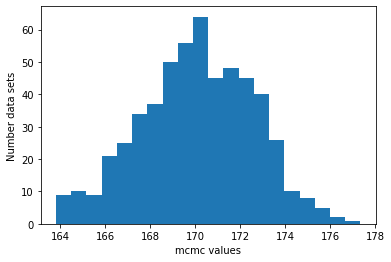

In [49]:
import numpy as np
import pylab as plt
import math
from scipy.stats import norm



def var_hat(var0, var, n):
    value =(var0*(var/n))/(var0+(var/n))
    return value

def mean_theta(var0, var, n, X, mean):
    value =(var0/(var0+(var/n)))*X+((var/n)/(var0+(var/n)))*mean
    return value

def prob_theta(var0, var, n, X, mean, theta):
    P_mean_theta = np.exp(-1*(((X-theta)**2)/(2*(var/n))))
    P_theta = np.exp(-1*(((theta-mean)**2)/var0))
    #P_theta_mean = float(P_mean_theta * P_theta)
    return P_theta

height = [169.6, 166.8, 157.1, 181.1, 158.4, 165.6, 166.7, 156.5, 168.1, 165.3]

variance = 50
variance0 = 9
theta = 165
n = len(height)
var_n = variance/n
std = np.sqrt(variance/n)
x = np.linspace(150,190,100)
mean = np.sum(height)/n
mean0 = 170


def mcmc(var0,var,n,X,mean,nsteps):
    accepted = []
    rejected = []
    random_values = np.random.normal(X,var,size = nsteps)
    accepted.append(random_values[0])
    for ii in range(1, nsteps):
        theta_current = accepted[-1]
        theta_pro = random_values[ii]
        prob_theta_pro = prob_theta(var0, var, n, X, mean, theta_pro)
        prob_theta_current = prob_theta(var0, var, n, X, mean, theta_current)
        p_move = min(prob_theta_pro/prob_theta_current,1)
        if p_move< 1:
            urnd = np.random.uniform()
            if urnd <= p_move:
                accepted.append(theta_pro)
                
            else:
                rejected.append(theta_pro)
        else:
            accepted.append(theta_pro)
    return np.array(accepted)

mcmc_array = mcmc(variance0, variance, n , mean, mean0, 10000)
plt.hist(mcmc_array,bins=20)

plt.xlabel('mcmc values')
plt.ylabel('Number data sets')


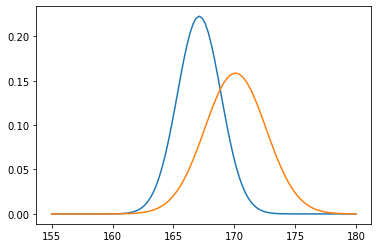

In [52]:
post_var = var_hat(variance0, variance, n)
post_mean = mean_theta(variance0, variance, n, mean, mean0)
post_std = np.sqrt(post_var)
mcmc_var = np.var(mcmc_array)
mcmc_std = np.sqrt(mcmc_var)
mcmc_mean = np.mean(mcmc_array)
x = np.linspace(155,180,100)
post_normal = norm.pdf(x,post_mean, post_std)
mcmc_normal = norm.pdf(x,mcmc_mean, mcmc_std)
plt.plot(x, post_normal)
plt.plot(x, mcmc_normal)

<div class="warn">Question:<br><br>

A company drills 9 wild-cat oil exploration wells, each with an estimated probability of success of 0.1. All nine wells fail. What is the probability of that happening? Tip: generate some random data.

</div>

**Answer:**